In [78]:
### Re-do helix fit with least squares from 4/18 with unwrapping parameters w_in, w_out

import numpy as np
import scipy
from scipy.optimize import curve_fit

#i = ith basepair, r = radius of helix, r0 = [x0, y0, z0] = center of base of cylinder,
#psi0 = initial phase, T = number of turns, b = number of basepairs, c = scaling factor,
#phi, theta = orientation of helix
def H(i, r, x0, y0, z0, psi0, T, c, phi, theta, b):
    ct = np.cos(theta)
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    R = np.array([[1 - st**2*(1-ct)*cp**2, -st**2*(1-ct)*sp*cp,    st**2*cp],
                  [-st**2*(1-ct)*sp*cp,    1 - st**2*(1-ct)*sp**2, st**2*sp],
                  [-st**2*cp,                -st**2*sp,            1 - st**2*(1-ct)]])
    phase = (2*np.pi*i*T)/b
    #note phase is negative: why? because when positive, fit doesn't work
    straight_helix = np.array([r*np.cos(-phase + psi0), r*np.sin(-phase + psi0), c*phase])
    return (np.dot(R, straight_helix).T + np.array([x0, y0, z0]))

#fix b = 146 bp (number of basepairs in 1idb nucleosome crystal structure)
H_fit = lambda i, r, x0, y0, z0, psi0, T, c, phi, theta: H(i, r, x0, y0, z0, psi0, T, c, phi, theta, b=146)

In [79]:
'''Define helix fitting routine that takes in the following parameters:
    @data: N x 3, where N is total number of basepairs
    @w_in: number of unwrapped base pairs on entry side to exclude from fit
    @w_out: number of unwrapped base pairs on exit side to exclude from fit '''


spokes = [[40.81800079345703, -43.76599884033203, -89.1240005493164], [43.108001708984375, -43.33000183105469, -86.50900268554688], [45.01900100708008, -42.39400100708008, -83.91400146484375], [44.77199935913086, -39.6349983215332, -80.88999938964844], [45.36199951171875, -39.06999969482422, -77.5719985961914], [46.59400177001953, -38.00199890136719, -74.78299713134766], [45.766998291015625, -39.547000885009766, -70.56999969482422], [45.78499984741211, -38.65700149536133, -67.33100128173828], [46.513999938964844, -39.766998291015625, -63.849998474121094], [46.84299850463867, -40.57699966430664, -60.611000061035156], [49.766998291015625, -40.069000244140625, -57.69200134277344], [50.80699920654297, -40.840999603271484, -54.51900100708008], [50.832000732421875, -37.64799880981445, -51.14099884033203], [50.43199920654297, -36.94900131225586, -46.9379997253418], [49.74300003051758, -34.013999938964844, -44.277000427246094], [49.948001861572266, -32.5359992980957, -41.374000549316406], [47.902000427246094, -31.80500030517578, -39.08399963378906], [46.946998596191406, -30.42300033569336, -35.941001892089844], [45.20100021362305, -31.577999114990234, -33.14799880981445], [43.42499923706055, -33.051998138427734, -30.381000518798828], [42.08399963378906, -32.722999572753906, -26.893999099731445], [41.92300033569336, -32.486000061035156, -22.92799949645996], [40.5880012512207, -29.84600067138672, -19.50200080871582], [36.2859992980957, -29.47100067138672, -18.520999908447266], [35.25299835205078, -26.510000228881836, -15.288999557495117], [32.69200134277344, -26.82900047302246, -14.58899974822998], [29.308000564575195, -25.96299934387207, -14.001999855041504], [25.73699951171875, -25.500999450683594, -13.37600040435791], [22.924999237060547, -26.929000854492188, -11.477999687194824], [19.91900062561035, -27.36400032043457, -10.678000450134277], [16.57900047302246, -28.097999572753906, -9.157999992370605], [13.22599983215332, -29.513999938964844, -8.508999824523926], [10.052000045776367, -28.39900016784668, -7.198999881744385], [6.456999778747559, -29.177000045776367, -5.6529998779296875], [3.6519999504089355, -27.357999801635742, -7.230000019073486], [-0.07800000160932541, -28.243000030517578, -6.875999927520752], [-2.938999891281128, -26.517000198364258, -9.696000099182129], [-6.309999942779541, -27.590999603271484, -12.347999572753906], [-8.972999572753906, -28.336999893188477, -14.614999771118164], [-11.119000434875488, -28.638999938964844, -17.381999969482422], [-13.295000076293945, -30.475000381469727, -19.34000015258789], [-16.524999618530273, -30.739999771118164, -20.341999053955078], [-20.45199966430664, -31.7810001373291, -22.493000030517578], [-22.770999908447266, -32.95500183105469, -25.106000900268555], [-24.410999298095703, -33.479000091552734, -27.500999450683594], [-25.868000030517578, -31.0939998626709, -30.80699920654297], [-28.27199935913086, -30.679000854492188, -33.03799819946289], [-28.739999771118164, -29.645999908447266, -37.08599853515625], [-29.77400016784668, -28.72100067138672, -40.654998779296875], [-28.288999557495117, -32.25199890136719, -43.891998291015625], [-29.729000091552734, -33.077999114990234, -46.7859992980957], [-30.052000045776367, -34.75899887084961, -49.5], [-31.708999633789062, -35.095001220703125, -52.46799850463867], [-32.637001037597656, -33.90800094604492, -56.518001556396484], [-32.54100036621094, -34.56100082397461, -59.64899826049805], [-32.750999450683594, -33.39400100708008, -63.060001373291016], [-30.732999801635742, -33.058998107910156, -66.71399688720703], [-29.37299919128418, -32.84400177001953, -70.38700103759766], [-27.08300018310547, -31.736000061035156, -73.77100372314453], [-24.030000686645508, -31.35700035095215, -75.08599853515625], [-22.94300079345703, -32.42499923706055, -77.96299743652344], [-20.534000396728516, -33.74800109863281, -80.29000091552734], [-17.910999298095703, -33.03799819946289, -84.49299621582031], [-15.696999549865723, -33.132999420166016, -87.13200378417969], [-13.42199993133545, -31.704999923706055, -89.24299621582031], [-10.666000366210938, -31.5049991607666, -90.30899810791016], [-7.081999778747559, -29.656999588012695, -90.45500183105469], [-4.026000022888184, -28.731000900268555, -91.51599884033203], [-0.12399999797344208, -26.73699951171875, -90.5510025024414], [3.1110000610351562, -27.11400032043457, -91.26100158691406], [6.125, -27.57699966430664, -91.35800170898438], [9.003999710083008, -27.381999969482422, -92.47599792480469], [13.01200008392334, -26.05299949645996, -92.61499786376953], [16.47800064086914, -25.617000579833984, -92.84200286865234], [19.584999084472656, -24.472000122070312, -93.03700256347656], [23.242000579833984, -22.672000885009766, -92.27999877929688], [26.23200035095215, -20.23200035095215, -91.2300033569336], [28.788000106811523, -19.44700050354004, -89.3280029296875], [30.427000045776367, -16.902000427246094, -86.0], [32.5369987487793, -16.711999893188477, -82.91799926757812], [35.9010009765625, -17.933000564575195, -81.63999938964844], [38.823001861572266, -17.990999221801758, -80.56700134277344],
 [41.42900085449219, -16.718000411987305, -79.00800323486328], [43.92399978637695, -16.961000442504883, -76.31999969482422], [45.05500030517578, -13.913000106811523, -73.00199890136719], [47.55500030517578, -12.321000099182129, -71.1760025024414], [48.680999755859375, -12.119999885559082, -67.052001953125], [48.902000427246094, -9.020999908447266, -63.694000244140625], [48.40399932861328, -7.929999828338623, -60.34000015258789], [46.88399887084961, -9.317000389099121, -56.263999938964844], [46.93199920654297, -9.753999710083008, -53.16400146484375], [47.74100112915039, -9.854000091552734, -50.04499816894531], [48.744998931884766, -9.668000221252441, -46.47700119018555], [48.617000579833984, -6.318999767303467, -44.33100128173828], [47.04600143432617, -5.692999839782715, -41.439998626708984], [46.520999908447266, -4.807000160217285, -37.95600128173828], [42.65700149536133, -3.3340001106262207, -36.2599983215332], [41.987998962402344, -3.5480000972747803, -33.00299835205078], [38.40299987792969, -2.6029999256134033, -31.746000289916992], [35.80400085449219, -1.9500000476837158, -28.468000411987305], [32.02799987792969, -3.4149999618530273, -27.927000045776367], [30.357999801635742, -2.628000020980835, -24.788999557495117], [28.743000030517578, -3.686000108718872, -21.20599937438965], [26.722999572753906, -3.6659998893737793, -18.55699920654297], [23.886999130249023, -3.11899995803833, -16.273000717163086], [21.05500030517578, -3.0929999351501465, -15.102999687194824], [17.974000930786133, -1.5, -13.069999694824219], [14.529999732971191, -0.28600001335144043, -12.407999992370605], [11.147000312805176, -0.13600000739097595, -13.159000396728516], [7.2829999923706055, -0.7720000147819519, -13.168999671936035], [3.9000000953674316, -1.5440000295639038, -12.770999908447266], [1.6139999628067017, -3.5950000286102295, -14.0600004196167], [-2.443000078201294, -3.0889999866485596, -11.614999771118164], [-5.626999855041504, -4.693999767303467, -11.437000274658203], [-9.145000457763672, -2.63100004196167, -12.13599967956543], [-12.78600025177002, -4.078999996185303, -13.168000221252441], [-15.857000350952148, -2.556999921798706, -15.211999893188477], [-18.485000610351562, -1.6799999475479126, -18.115999221801758], [-20.722000122070312, -1.9639999866485596, -21.215999603271484], [-22.058000564575195, -3.322999954223633, -24.632999420166016], [-23.909000396728516, -4.019999980926514, -27.735000610351562], [-25.885000228881836, -6.01800012588501, -29.21500015258789], [-27.47800064086914, -6.88700008392334, -31.93199920654297], [-31.402000427246094, -7.125, -32.62799835205078], [-31.45199966430664, -6.629000186920166, -36.55400085449219], [-34.744998931884766, -5.017000198364258, -38.48099899291992], [-34.797000885009766, -4.25, -42.50299835205078], [-36.722999572753906, -5.676000118255615, -45.13199996948242], [-35.625, -3.549999952316284, -48.8650016784668], [-34.53799819946289, -3.9809999465942383, -52.8129997253418], [-33.04499816894531, -4.7779998779296875, -56.24700164794922], [-31.53499984741211, -3.361999988555908, -59.729000091552734], [-31.520000457763672, -5.395999908447266, -63.119998931884766], [-31.663999557495117, -5.749000072479248, -66.44300079345703], [-31.959999084472656, -6.186999797821045, -69.83100128173828], [-32.763999938964844, -5.3470001220703125, -73.75499725341797], [-30.781999588012695, -5.7129998207092285, -76.39700317382812], [-29.048999786376953, -4.580999851226807, -79.33799743652344], [-26.33799934387207, -3.8499999046325684, -81.50800323486328], [-24.73900032043457, -4.079999923706055, -84.68699645996094], [-21.96500015258789, -7.059000015258789, -86.78500366210938], [-19.417999267578125, -7.276000022888184, -88.79499816894531], [-18.1299991607666, -9.418999671936035, -91.29399871826172], [-16.91200065612793, -9.197999954223633, -94.39199829101562], [-17.21500015258789, -10.321999549865723, -98.20099639892578], [-14.819999694824219, -11.279999732971191, -100.28500366210938], [-14.807000160217285, -7.920000076293945, -100.28900146484375], [-18.14699935913086, -7.668000221252441, -98.67900085449219], [-20.288999557495117, -8.442000389099121, -96.3949966430664], [-20.81100082397461, -9.427000045776367, -92.97599792480469], [-21.920000076293945, -9.510000228881836, -90.06700134277344], [-23.913999557495117, -9.406999588012695, -87.18399810791016], [-23.764999389648438, -6.723999977111816, -83.95500183105469], [-24.788000106811523, -6.63100004196167, -80.54399871826172], [-26.30699920654297, -4.818999767303467, -77.47599792480469], [-27.767000198364258, -2.8919999599456787, -75.50800323486328], [-31.035999298095703, -1.8600000143051147, -73.3759994506836], [-32.86800003051758, -2.1579999923706055, -70.21900177001953], [-33.55099868774414, -2.5920000076293945, -66.96900177001953], [-34.263999938964844, -3.865000009536743, -63.176998138427734], [-34.321998596191406, -5.118000030517578, -59.4900016784668], [-35.62799835205078, -7.1539998054504395, -56.12699890136719], [-33.888999938964844, -7.34499979019165, -52.5890007019043], [-34.665000915527344, -7.613999843597412, -49.33100128173828], [-33.42900085449219, -5.116000175476074, -46.672000885009766], [-31.91900062561035, -4.230999946594238, -43.83700180053711], [-31.93600082397461, -1.7890000343322754, -40.60599899291992], [-33.4010009765625, -2.8929998874664307, -37.37300109863281], [-31.96500015258789, -1.5130000114440918, -33.62200164794922], [-29.604999542236328, -5.223999977111816, -31.593000411987305], [-28.4950008392334, -4.855999946594238, -27.391000747680664], [-25.638999938964844, -4.908999919891357, -25.356000900268555], [-22.885000228881836, -6.158999919891357, -23.058000564575195], [-20.364999771118164, -5.144000053405762, -21.10300064086914], [-17.691999435424805, -4.126999855041504, -19.746999740600586], [-14.751999855041504, -2.9600000381469727, -18.226999282836914], [-12.065999984741211, -2.1760001182556152, -15.66100025177002], [-9.045000076293945, -0.9290000200271606, -15.029999732971191], [-5.853000164031982, -1.6649999618530273, -11.628999710083008], [-3.1470000743865967, -0.026000000536441803, -9.947999954223633], [0.39500001072883606, -2.8410000801086426, -10.83899974822998], [3.993000030517578, -2.3259999752044678, -9.614999771118164], [7.690999984741211, -2.5799999237060547, -10.654000282287598], [11.175000190734863, -2.7360000610351562, -11.840999603271484], [15.680999755859375, -5.9710001945495605, -13.428999900817871], [16.878000259399414, -2.240999937057495, -15.991000175476074], [19.558000564575195, -1.0230000019073486, -17.774999618530273], [23.466999053955078, -0.5860000252723694, -18.391000747680664], [26.511999130249023, -0.7160000205039978, -19.451000213623047], [29.270000457763672, -0.18000000715255737, -20.402999877929688], [31.95800018310547, -0.2619999945163727, -22.93000030517578], [34.49800109863281, -3.878999948501587, -25.792999267578125], [38.00199890136719, -3.931999921798706, -27.0], [38.888999938964844, -5.988999843597412, -30.610000610351562], [41.18000030517578, -7.067999839782715, -33.59600067138672], [40.52299880981445, -5.168000221252441, -37.81100082397461], [43.24399948120117, -3.9040000438690186, -39.599998474121094], [44.38800048828125, -4.0879998207092285, -42.680999755859375], [47.54600143432617, -3.36299991607666, -45.275001525878906], [48.72700119018555, -6.724999904632568, -47.540000915527344], [50.88399887084961, -7.5229997634887695, -50.79499816894531], [50.768001556396484, -9.289999961853027, -53.61000061035156], [49.983001708984375, -9.342000007629395, -57.099998474121094], [50.31399917602539, -10.112000465393066, -60.180999755859375], [47.915000915527344, -12.317999839782715, -63.209999084472656], [46.51300048828125, -14.482000350952148, -66.21900177001953], [44.89899826049805, -13.253000259399414, -69.64399719238281], [42.5099983215332, -12.611000061035156, -72.00299835205078], [43.11899948120117, -13.503999710083008, -75.76799774169922], [41.38100051879883, -13.13700008392334, -78.83499908447266], [39.8489990234375, -15.616000175476074, -82.3489990234375], [37.374000549316406, -16.940000534057617, -84.2020034790039], [34.03900146484375, -17.701000213623047, -84.96199798583984], [31.09000015258789, -19.722999572753906, -87.21399688720703], [28.895000457763672, -22.534000396728516, -88.87100219726562], [24.98900032043457, -21.75, -88.822998046875], [21.795000076293945, -22.19300079345703, -89.30599975585938], [18.69499969482422, -22.350000381469727, -90.59500122070312], [15.635000228881836, -22.42300033569336, -91.79399871826172], [12.168000221252441, -22.41200065612793, -92.60900115966797], [9.184000015258789, -24.760000228881836, -94.60399627685547], [5.940000057220459, -26.006000518798828, -94.67900085449219], [2.3480000495910645, -28.117000579833984, -93.98200225830078], [-0.5339999794960022, -29.53700065612793, -92.32499694824219], [-3.691999912261963, -31.531999588012695, -92.09300231933594], [-6.406000137329102, -31.663000106811523, -88.6449966430664], [-9.510000228881836, -31.402999877929688, -87.61299896240234], [-12.604000091552734, -30.136999130249023, -86.81500244140625], [-15.581999778747559, -30.75, -85.76100158691406], [-18.402000427246094, -30.077999114990234, -84.13800048828125], [-21.643999099731445, -31.579999923706055, -82.01599884033203], [-24.819000244140625, -30.948999404907227, -80.0270004272461], [-26.7810001373291, -32.10300064086914, -77.05400085449219], [-30.85300064086914, -34.922000885009766, -72.88400268554688], [-30.523000717163086, -36.32899856567383, -69.6050033569336], [-29.086000442504883, -35.369998931884766, -66.22200012207031], [-28.81599998474121, -34.150001525878906, -62.803001403808594], [-30.16200065612793, -31.923999786376953, -60.020999908447266], [-31.64699935913086, -31.07200050354004, -56.73899841308594], [-32.902000427246094, -31.974000930786133, -53.625], [-32.46200180053711, -32.638999938964844, -49.737998962402344], [-32.56999969482422, -31.750999450683594, -46.35499954223633], [-31.261999130249023, -33.6870002746582, -42.957000732421875], 
          [-31.06999969482422, -31.92099952697754, -40.082000732421875], [-28.145999908447266, -32.99700164794922, -37.2760009765625], [-26.389999389648438, -32.89099884033203, -33.888999938964844], [-22.916000366210938, -31.84600067138672, -32.21200180053711], [-22.104999542236328, -31.027999877929688, -29.16200065612793], [-20.97599983215332, -29.986000061035156, -25.591999053955078], [-19.368000030517578, -28.155000686645508, -22.902000427246094], [-18.43199920654297, -29.086000442504883, -18.902999877929688], [-14.70199966430664, -29.024999618530273, -17.082000732421875], [-12.439000129699707, -29.375, -13.366000175476074], [-9.241999626159668, -30.354000091552734, -11.565999984741211], [-5.598999977111816, -30.60099983215332, -11.637999534606934], [-2.4539999961853027, -29.309999465942383, -11.293000221252441], [0.6370000243186951, -28.14299964904785, -10.39799976348877], [3.7079999446868896, -26.797000885009766, -10.925000190734863], [7.320000171661377, -26.854000091552734, -7.0980000495910645], [9.621999740600586, -24.158000946044922, -7.379000186920166], [12.85200023651123, -26.613000869750977, -6.492000102996826], [16.476999282836914, -26.073999404907227, -6.909999847412109], [20.27400016784668, -26.950000762939453, -7.443999767303467], [23.31399917602539, -28.961999893188477, -9.196999549865723], [26.40999984741211, -29.3439998626709, -11.612000465393066], [28.458999633789062, -29.68000030517578, -14.482999801635742], [31.048999786376953, -29.038999557495117, -17.149999618530273], [33.04399871826172, -27.524999618530273, -19.190000534057617], [34.790000915527344, -26.086999893188477, -21.586999893188477], [40.19499969482422, -25.702999114990234, -21.172000885009766], [41.27799987792969, -28.149999618530273, -23.714000701904297], [43.86000061035156, -29.655000686645508, -25.23699951171875], [46.03499984741211, -32.69499969482422, -27.20199966430664], [47.762001037597656, -31.55699920654297, -30.117000579833984], [47.84700012207031, -34.005001068115234, -34.45899963378906], [48.391998291015625, -34.6879997253418, -38.06399917602539], [47.41600036621094, -34.67599868774414, -42.34199905395508], [46.91899871826172, -36.46900177001953, -45.0629997253418], [48.11800003051758, 
-35.361000061035156, -48.417999267578125], [48.632999420166016, -35.46099853515625, -52.07400131225586], [50.95800018310547, -37.34199905395508, -54.69499969482422], [52.047000885009766, -37.92499923706055, -58.27399826049805], [49.856998443603516, -40.20800018310547, -60.90700149536133], [49.56100082397461, -41.18899917602539, -64.30699920654297], [47.25, -41.775001525878906, -67.18900299072266], [47.0099983215332, -42.7239990234375, -70.39700317382812], [45.15599822998047, -40.0880012512207, -73.97100067138672], [42.7869987487793, -40.40399932861328, -76.5], [42.106998443603516, -39.32600021362305, -79.56300354003906], [42.72600173950195, -40.111000061035156, -83.13999938964844], [42.819000244140625, -40.391998291015625, -86.55400085449219], [41.3380012512207, -40.69300079345703, -89.92900085449219]]

data = np.array(spokes).reshape(292, 3)
w_in = 7
w_out = 7

b = data.shape[0] / 2 #divide by 2 because 2 data points per base pair
#re-order data to be in consecutive order, 2 points per basepair
spokes_ordered = np.ones(data.shape)
spokes_ordered[::2] = data[0:b]
spokes_ordered[1::2] = data[b:][::-1]
basepairs = np.arange(0, b) #i values from i=0, ..., 145 (assuming b = 146)
bp_wrapped = basepairs[w_in:(b - w_out)]
bp_index = np.repeat(bp_wrapped, 2) #w_in, w_in, ... b-w_out-1, b-w_out-1
#exclude data points in unwrapped regions
data_to_fit = spokes_ordered[(2*w_in):-(2*w_out), :]

#initial guess for parameters
r = 43.0
r0 = np.array([10., -45., -52.])
x0 = r0[0]
y0 = r0[1]
z0 = r0[2]
psi0 = 0.75*np.pi/2.0
T = 1.8
c = 4.2
phi = (1.1*np.pi/2.0)
theta = (-1.1*np.pi / 2.0)
#in PyMol z-axis is orthogonal to helical axis
initial_params = [r, x0, y0, z0, psi0, T, c, phi, theta]
param_bounds = ([35., 0., -60., -100., 0.5*(np.pi/2), 1.7,  3.5, np.pi/2, -1.5*np.pi/2], 
                [50., 20., -40., -20.,      np.pi/2, 2.1, 5.0, np.pi, -0.8*np.pi/2])

#manually define energy function (norm of L2 distances from helix)
def func(params):
    return np.linalg.norm(np.linalg.norm(H_fit(bp_index, *params) - data_to_fit, axis=1))

# popt, pcov = curve_fit(H_fit, bp_index, data, initial_params, bounds = param_bounds)
opt = scipy.optimize.least_squares(func, initial_params, x_scale=[3*np.sqrt(2), 1, 1, 1, np.pi/2000, 0.001, 1, np.pi/2000, np.pi/2000], jac='2-point', bounds=param_bounds, method='trf', max_nfev=None)
print opt
    

[  7   7   8   8   9   9  10  10  11  11  12  12  13  13  14  14  15  15
  16  16  17  17  18  18  19  19  20  20  21  21  22  22  23  23  24  24
  25  25  26  26  27  27  28  28  29  29  30  30  31  31  32  32  33  33
  34  34  35  35  36  36  37  37  38  38  39  39  40  40  41  41  42  42
  43  43  44  44  45  45  46  46  47  47  48  48  49  49  50  50  51  51
  52  52  53  53  54  54  55  55  56  56  57  57  58  58  59  59  60  60
  61  61  62  62  63  63  64  64  65  65  66  66  67  67  68  68  69  69
  70  70  71  71  72  72  73  73  74  74  75  75  76  76  77  77  78  78
  79  79  80  80  81  81  82  82  83  83  84  84  85  85  86  86  87  87
  88  88  89  89  90  90  91  91  92  92  93  93  94  94  95  95  96  96
  97  97  98  98  99  99 100 100 101 101 102 102 103 103 104 104 105 105
 106 106 107 107 108 108 109 109 110 110 111 111 112 112 113 113 114 114
 115 115 116 116 117 117 118 118 119 119 120 120 121 121 122 122 123 123
 124 124 125 125 126 126 127 127 128 128 129 129 13

<IPython.core.display.Javascript object>


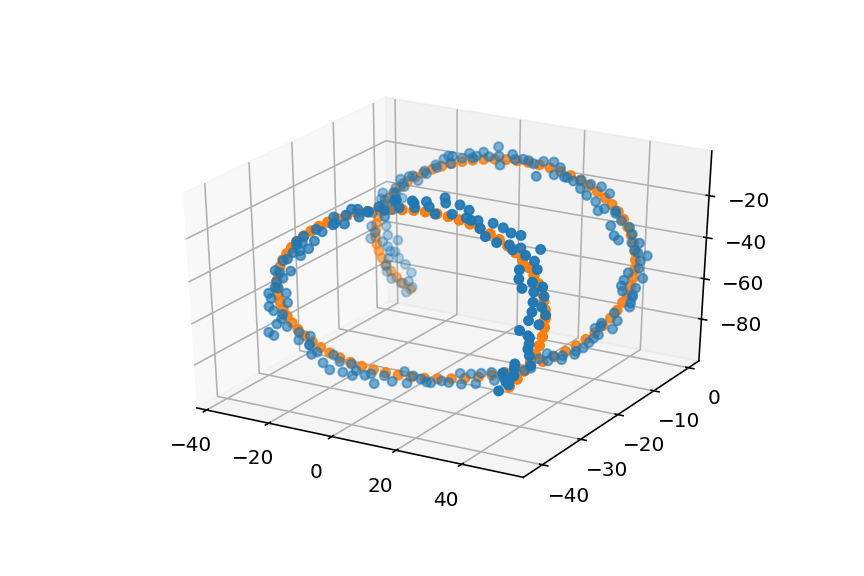

41.6639847689


In [152]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fitted_params = opt.x

#FINAL FIT OF HELIX with 7 basepairs unwrapped on entry and exit
lsfit = H_fit(bp_index, *fitted_params)
ax.scatter(data_to_fit[:,0], data_to_fit[:,1], data_to_fit[:,2])
ax.scatter(lsfit[:,0], lsfit[:,1], lsfit[:,2])
print func(opt.x)

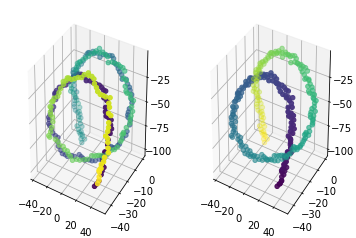

In [102]:
### Test out re-ordering of data points on helix

spokes = [[40.81800079345703, -43.76599884033203, -89.1240005493164], [43.108001708984375, -43.33000183105469, -86.50900268554688], [45.01900100708008, -42.39400100708008, -83.91400146484375], [44.77199935913086, -39.6349983215332, -80.88999938964844], [45.36199951171875, -39.06999969482422, -77.5719985961914], [46.59400177001953, -38.00199890136719, -74.78299713134766], [45.766998291015625, -39.547000885009766, -70.56999969482422], [45.78499984741211, -38.65700149536133, -67.33100128173828], [46.513999938964844, -39.766998291015625, -63.849998474121094], [46.84299850463867, -40.57699966430664, -60.611000061035156], [49.766998291015625, -40.069000244140625, -57.69200134277344], [50.80699920654297, -40.840999603271484, -54.51900100708008], [50.832000732421875, -37.64799880981445, -51.14099884033203], [50.43199920654297, -36.94900131225586, -46.9379997253418], [49.74300003051758, -34.013999938964844, -44.277000427246094], [49.948001861572266, -32.5359992980957, -41.374000549316406], [47.902000427246094, -31.80500030517578, -39.08399963378906], [46.946998596191406, -30.42300033569336, -35.941001892089844], [45.20100021362305, -31.577999114990234, -33.14799880981445], [43.42499923706055, -33.051998138427734, -30.381000518798828], [42.08399963378906, -32.722999572753906, -26.893999099731445], [41.92300033569336, -32.486000061035156, -22.92799949645996], [40.5880012512207, -29.84600067138672, -19.50200080871582], [36.2859992980957, -29.47100067138672, -18.520999908447266], [35.25299835205078, -26.510000228881836, -15.288999557495117], [32.69200134277344, -26.82900047302246, -14.58899974822998], [29.308000564575195, -25.96299934387207, -14.001999855041504], [25.73699951171875, -25.500999450683594, -13.37600040435791], [22.924999237060547, -26.929000854492188, -11.477999687194824], [19.91900062561035, -27.36400032043457, -10.678000450134277], [16.57900047302246, -28.097999572753906, -9.157999992370605], [13.22599983215332, -29.513999938964844, -8.508999824523926], [10.052000045776367, -28.39900016784668, -7.198999881744385], [6.456999778747559, -29.177000045776367, -5.6529998779296875], [3.6519999504089355, -27.357999801635742, -7.230000019073486], [-0.07800000160932541, -28.243000030517578, -6.875999927520752], [-2.938999891281128, -26.517000198364258, -9.696000099182129], [-6.309999942779541, -27.590999603271484, -12.347999572753906], [-8.972999572753906, -28.336999893188477, -14.614999771118164], [-11.119000434875488, -28.638999938964844, -17.381999969482422], [-13.295000076293945, -30.475000381469727, -19.34000015258789], [-16.524999618530273, -30.739999771118164, -20.341999053955078], [-20.45199966430664, -31.7810001373291, -22.493000030517578], [-22.770999908447266, -32.95500183105469, -25.106000900268555], [-24.410999298095703, -33.479000091552734, -27.500999450683594], [-25.868000030517578, -31.0939998626709, -30.80699920654297], [-28.27199935913086, -30.679000854492188, -33.03799819946289], [-28.739999771118164, -29.645999908447266, -37.08599853515625], [-29.77400016784668, -28.72100067138672, -40.654998779296875], [-28.288999557495117, -32.25199890136719, -43.891998291015625], [-29.729000091552734, -33.077999114990234, -46.7859992980957], [-30.052000045776367, -34.75899887084961, -49.5], [-31.708999633789062, -35.095001220703125, -52.46799850463867], [-32.637001037597656, -33.90800094604492, -56.518001556396484], [-32.54100036621094, -34.56100082397461, -59.64899826049805], [-32.750999450683594, -33.39400100708008, -63.060001373291016], [-30.732999801635742, -33.058998107910156, -66.71399688720703], [-29.37299919128418, -32.84400177001953, -70.38700103759766], [-27.08300018310547, -31.736000061035156, -73.77100372314453], [-24.030000686645508, -31.35700035095215, -75.08599853515625], [-22.94300079345703, -32.42499923706055, -77.96299743652344], [-20.534000396728516, -33.74800109863281, -80.29000091552734], [-17.910999298095703, -33.03799819946289, -84.49299621582031], [-15.696999549865723, -33.132999420166016, -87.13200378417969], [-13.42199993133545, -31.704999923706055, -89.24299621582031], [-10.666000366210938, -31.5049991607666, -90.30899810791016], [-7.081999778747559, -29.656999588012695, -90.45500183105469], [-4.026000022888184, -28.731000900268555, -91.51599884033203], [-0.12399999797344208, -26.73699951171875, -90.5510025024414], [3.1110000610351562, -27.11400032043457, -91.26100158691406], [6.125, -27.57699966430664, -91.35800170898438], [9.003999710083008, -27.381999969482422, -92.47599792480469], [13.01200008392334, -26.05299949645996, -92.61499786376953], [16.47800064086914, -25.617000579833984, -92.84200286865234], [19.584999084472656, -24.472000122070312, -93.03700256347656], [23.242000579833984, -22.672000885009766, -92.27999877929688], [26.23200035095215, -20.23200035095215, -91.2300033569336], [28.788000106811523, -19.44700050354004, -89.3280029296875], [30.427000045776367, -16.902000427246094, -86.0], [32.5369987487793, -16.711999893188477, -82.91799926757812], [35.9010009765625, -17.933000564575195, -81.63999938964844], [38.823001861572266, -17.990999221801758, -80.56700134277344],
 [41.42900085449219, -16.718000411987305, -79.00800323486328], [43.92399978637695, -16.961000442504883, -76.31999969482422], [45.05500030517578, -13.913000106811523, -73.00199890136719], [47.55500030517578, -12.321000099182129, -71.1760025024414], [48.680999755859375, -12.119999885559082, -67.052001953125], [48.902000427246094, -9.020999908447266, -63.694000244140625], [48.40399932861328, -7.929999828338623, -60.34000015258789], [46.88399887084961, -9.317000389099121, -56.263999938964844], [46.93199920654297, -9.753999710083008, -53.16400146484375], [47.74100112915039, -9.854000091552734, -50.04499816894531], [48.744998931884766, -9.668000221252441, -46.47700119018555], [48.617000579833984, -6.318999767303467, -44.33100128173828], [47.04600143432617, -5.692999839782715, -41.439998626708984], [46.520999908447266, -4.807000160217285, -37.95600128173828], [42.65700149536133, -3.3340001106262207, -36.2599983215332], [41.987998962402344, -3.5480000972747803, -33.00299835205078], [38.40299987792969, -2.6029999256134033, -31.746000289916992], [35.80400085449219, -1.9500000476837158, -28.468000411987305], [32.02799987792969, -3.4149999618530273, -27.927000045776367], [30.357999801635742, -2.628000020980835, -24.788999557495117], [28.743000030517578, -3.686000108718872, -21.20599937438965], [26.722999572753906, -3.6659998893737793, -18.55699920654297], [23.886999130249023, -3.11899995803833, -16.273000717163086], [21.05500030517578, -3.0929999351501465, -15.102999687194824], [17.974000930786133, -1.5, -13.069999694824219], [14.529999732971191, -0.28600001335144043, -12.407999992370605], [11.147000312805176, -0.13600000739097595, -13.159000396728516], [7.2829999923706055, -0.7720000147819519, -13.168999671936035], [3.9000000953674316, -1.5440000295639038, -12.770999908447266], [1.6139999628067017, -3.5950000286102295, -14.0600004196167], [-2.443000078201294, -3.0889999866485596, -11.614999771118164], [-5.626999855041504, -4.693999767303467, -11.437000274658203], [-9.145000457763672, -2.63100004196167, -12.13599967956543], [-12.78600025177002, -4.078999996185303, -13.168000221252441], [-15.857000350952148, -2.556999921798706, -15.211999893188477], [-18.485000610351562, -1.6799999475479126, -18.115999221801758], [-20.722000122070312, -1.9639999866485596, -21.215999603271484], [-22.058000564575195, -3.322999954223633, -24.632999420166016], [-23.909000396728516, -4.019999980926514, -27.735000610351562], [-25.885000228881836, -6.01800012588501, -29.21500015258789], [-27.47800064086914, -6.88700008392334, -31.93199920654297], [-31.402000427246094, -7.125, -32.62799835205078], [-31.45199966430664, -6.629000186920166, -36.55400085449219], [-34.744998931884766, -5.017000198364258, -38.48099899291992], [-34.797000885009766, -4.25, -42.50299835205078], [-36.722999572753906, -5.676000118255615, -45.13199996948242], [-35.625, -3.549999952316284, -48.8650016784668], [-34.53799819946289, -3.9809999465942383, -52.8129997253418], [-33.04499816894531, -4.7779998779296875, -56.24700164794922], [-31.53499984741211, -3.361999988555908, -59.729000091552734], [-31.520000457763672, -5.395999908447266, -63.119998931884766], [-31.663999557495117, -5.749000072479248, -66.44300079345703], [-31.959999084472656, -6.186999797821045, -69.83100128173828], [-32.763999938964844, -5.3470001220703125, -73.75499725341797], [-30.781999588012695, -5.7129998207092285, -76.39700317382812], [-29.048999786376953, -4.580999851226807, -79.33799743652344], [-26.33799934387207, -3.8499999046325684, -81.50800323486328], [-24.73900032043457, -4.079999923706055, -84.68699645996094], [-21.96500015258789, -7.059000015258789, -86.78500366210938], [-19.417999267578125, -7.276000022888184, -88.79499816894531], [-18.1299991607666, -9.418999671936035, -91.29399871826172], [-16.91200065612793, -9.197999954223633, -94.39199829101562], [-17.21500015258789, -10.321999549865723, -98.20099639892578], [-14.819999694824219, -11.279999732971191, -100.28500366210938], [-14.807000160217285, -7.920000076293945, -100.28900146484375], [-18.14699935913086, -7.668000221252441, -98.67900085449219], [-20.288999557495117, -8.442000389099121, -96.3949966430664], [-20.81100082397461, -9.427000045776367, -92.97599792480469], [-21.920000076293945, -9.510000228881836, -90.06700134277344], [-23.913999557495117, -9.406999588012695, -87.18399810791016], [-23.764999389648438, -6.723999977111816, -83.95500183105469], [-24.788000106811523, -6.63100004196167, -80.54399871826172], [-26.30699920654297, -4.818999767303467, -77.47599792480469], [-27.767000198364258, -2.8919999599456787, -75.50800323486328], [-31.035999298095703, -1.8600000143051147, -73.3759994506836], [-32.86800003051758, -2.1579999923706055, -70.21900177001953], [-33.55099868774414, -2.5920000076293945, -66.96900177001953], [-34.263999938964844, -3.865000009536743, -63.176998138427734], [-34.321998596191406, -5.118000030517578, -59.4900016784668], [-35.62799835205078, -7.1539998054504395, -56.12699890136719], [-33.888999938964844, -7.34499979019165, -52.5890007019043], [-34.665000915527344, -7.613999843597412, -49.33100128173828], [-33.42900085449219, -5.116000175476074, -46.672000885009766], [-31.91900062561035, -4.230999946594238, -43.83700180053711], [-31.93600082397461, -1.7890000343322754, -40.60599899291992], [-33.4010009765625, -2.8929998874664307, -37.37300109863281], [-31.96500015258789, -1.5130000114440918, -33.62200164794922], [-29.604999542236328, -5.223999977111816, -31.593000411987305], [-28.4950008392334, -4.855999946594238, -27.391000747680664], [-25.638999938964844, -4.908999919891357, -25.356000900268555], [-22.885000228881836, -6.158999919891357, -23.058000564575195], [-20.364999771118164, -5.144000053405762, -21.10300064086914], [-17.691999435424805, -4.126999855041504, -19.746999740600586], [-14.751999855041504, -2.9600000381469727, -18.226999282836914], [-12.065999984741211, -2.1760001182556152, -15.66100025177002], [-9.045000076293945, -0.9290000200271606, -15.029999732971191], [-5.853000164031982, -1.6649999618530273, -11.628999710083008], [-3.1470000743865967, -0.026000000536441803, -9.947999954223633], [0.39500001072883606, -2.8410000801086426, -10.83899974822998], [3.993000030517578, -2.3259999752044678, -9.614999771118164], [7.690999984741211, -2.5799999237060547, -10.654000282287598], [11.175000190734863, -2.7360000610351562, -11.840999603271484], [15.680999755859375, -5.9710001945495605, -13.428999900817871], [16.878000259399414, -2.240999937057495, -15.991000175476074], [19.558000564575195, -1.0230000019073486, -17.774999618530273], [23.466999053955078, -0.5860000252723694, -18.391000747680664], [26.511999130249023, -0.7160000205039978, -19.451000213623047], [29.270000457763672, -0.18000000715255737, -20.402999877929688], [31.95800018310547, -0.2619999945163727, -22.93000030517578], [34.49800109863281, -3.878999948501587, -25.792999267578125], [38.00199890136719, -3.931999921798706, -27.0], [38.888999938964844, -5.988999843597412, -30.610000610351562], [41.18000030517578, -7.067999839782715, -33.59600067138672], [40.52299880981445, -5.168000221252441, -37.81100082397461], [43.24399948120117, -3.9040000438690186, -39.599998474121094], [44.38800048828125, -4.0879998207092285, -42.680999755859375], [47.54600143432617, -3.36299991607666, -45.275001525878906], [48.72700119018555, -6.724999904632568, -47.540000915527344], [50.88399887084961, -7.5229997634887695, -50.79499816894531], [50.768001556396484, -9.289999961853027, -53.61000061035156], [49.983001708984375, -9.342000007629395, -57.099998474121094], [50.31399917602539, -10.112000465393066, -60.180999755859375], [47.915000915527344, -12.317999839782715, -63.209999084472656], [46.51300048828125, -14.482000350952148, -66.21900177001953], [44.89899826049805, -13.253000259399414, -69.64399719238281], [42.5099983215332, -12.611000061035156, -72.00299835205078], [43.11899948120117, -13.503999710083008, -75.76799774169922], [41.38100051879883, -13.13700008392334, -78.83499908447266], [39.8489990234375, -15.616000175476074, -82.3489990234375], [37.374000549316406, -16.940000534057617, -84.2020034790039], [34.03900146484375, -17.701000213623047, -84.96199798583984], [31.09000015258789, -19.722999572753906, -87.21399688720703], [28.895000457763672, -22.534000396728516, -88.87100219726562], [24.98900032043457, -21.75, -88.822998046875], [21.795000076293945, -22.19300079345703, -89.30599975585938], [18.69499969482422, -22.350000381469727, -90.59500122070312], [15.635000228881836, -22.42300033569336, -91.79399871826172], [12.168000221252441, -22.41200065612793, -92.60900115966797], [9.184000015258789, -24.760000228881836, -94.60399627685547], [5.940000057220459, -26.006000518798828, -94.67900085449219], [2.3480000495910645, -28.117000579833984, -93.98200225830078], [-0.5339999794960022, -29.53700065612793, -92.32499694824219], [-3.691999912261963, -31.531999588012695, -92.09300231933594], [-6.406000137329102, -31.663000106811523, -88.6449966430664], [-9.510000228881836, -31.402999877929688, -87.61299896240234], [-12.604000091552734, -30.136999130249023, -86.81500244140625], [-15.581999778747559, -30.75, -85.76100158691406], [-18.402000427246094, -30.077999114990234, -84.13800048828125], [-21.643999099731445, -31.579999923706055, -82.01599884033203], [-24.819000244140625, -30.948999404907227, -80.0270004272461], [-26.7810001373291, -32.10300064086914, -77.05400085449219], [-30.85300064086914, -34.922000885009766, -72.88400268554688], [-30.523000717163086, -36.32899856567383, -69.6050033569336], [-29.086000442504883, -35.369998931884766, -66.22200012207031], [-28.81599998474121, -34.150001525878906, -62.803001403808594], [-30.16200065612793, -31.923999786376953, -60.020999908447266], [-31.64699935913086, -31.07200050354004, -56.73899841308594], [-32.902000427246094, -31.974000930786133, -53.625], [-32.46200180053711, -32.638999938964844, -49.737998962402344], [-32.56999969482422, -31.750999450683594, -46.35499954223633], [-31.261999130249023, -33.6870002746582, -42.957000732421875], 
          [-31.06999969482422, -31.92099952697754, -40.082000732421875], [-28.145999908447266, -32.99700164794922, -37.2760009765625], [-26.389999389648438, -32.89099884033203, -33.888999938964844], [-22.916000366210938, -31.84600067138672, -32.21200180053711], [-22.104999542236328, -31.027999877929688, -29.16200065612793], [-20.97599983215332, -29.986000061035156, -25.591999053955078], [-19.368000030517578, -28.155000686645508, -22.902000427246094], [-18.43199920654297, -29.086000442504883, -18.902999877929688], [-14.70199966430664, -29.024999618530273, -17.082000732421875], [-12.439000129699707, -29.375, -13.366000175476074], [-9.241999626159668, -30.354000091552734, -11.565999984741211], [-5.598999977111816, -30.60099983215332, -11.637999534606934], [-2.4539999961853027, -29.309999465942383, -11.293000221252441], [0.6370000243186951, -28.14299964904785, -10.39799976348877], [3.7079999446868896, -26.797000885009766, -10.925000190734863], [7.320000171661377, -26.854000091552734, -7.0980000495910645], [9.621999740600586, -24.158000946044922, -7.379000186920166], [12.85200023651123, -26.613000869750977, -6.492000102996826], [16.476999282836914, -26.073999404907227, -6.909999847412109], [20.27400016784668, -26.950000762939453, -7.443999767303467], [23.31399917602539, -28.961999893188477, -9.196999549865723], [26.40999984741211, -29.3439998626709, -11.612000465393066], [28.458999633789062, -29.68000030517578, -14.482999801635742], [31.048999786376953, -29.038999557495117, -17.149999618530273], [33.04399871826172, -27.524999618530273, -19.190000534057617], [34.790000915527344, -26.086999893188477, -21.586999893188477], [40.19499969482422, -25.702999114990234, -21.172000885009766], [41.27799987792969, -28.149999618530273, -23.714000701904297], [43.86000061035156, -29.655000686645508, -25.23699951171875], [46.03499984741211, -32.69499969482422, -27.20199966430664], [47.762001037597656, -31.55699920654297, -30.117000579833984], [47.84700012207031, -34.005001068115234, -34.45899963378906], [48.391998291015625, -34.6879997253418, -38.06399917602539], [47.41600036621094, -34.67599868774414, -42.34199905395508], [46.91899871826172, -36.46900177001953, -45.0629997253418], [48.11800003051758, 
-35.361000061035156, -48.417999267578125], [48.632999420166016, -35.46099853515625, -52.07400131225586], [50.95800018310547, -37.34199905395508, -54.69499969482422], [52.047000885009766, -37.92499923706055, -58.27399826049805], [49.856998443603516, -40.20800018310547, -60.90700149536133], [49.56100082397461, -41.18899917602539, -64.30699920654297], [47.25, -41.775001525878906, -67.18900299072266], [47.0099983215332, -42.7239990234375, -70.39700317382812], [45.15599822998047, -40.0880012512207, -73.97100067138672], [42.7869987487793, -40.40399932861328, -76.5], [42.106998443603516, -39.32600021362305, -79.56300354003906], [42.72600173950195, -40.111000061035156, -83.13999938964844], [42.819000244140625, -40.391998291015625, -86.55400085449219], [41.3380012512207, -40.69300079345703, -89.92900085449219]]

spokes = np.array(spokes).reshape(292, 3)

#original data
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
spokes = np.array(spokes)
ax.scatter(spokes[:,0], spokes[:,1], spokes[:,2], c=np.arange(spokes.shape[0]))

#try reordering data
ax = fig.add_subplot(122, projection='3d')
spokes_ordered = np.ones(spokes.shape)
spokes_ordered[::2] = spokes[0:146]
spokes_ordered[1::2] = spokes[146:][::-1]
ax.scatter(spokes_ordered[:,0], spokes_ordered[:,1], spokes_ordered[:,2], c=np.arange(spokes_ordered.shape[0]))

[  0   0   1   1   2   2   3   3   4   4   5   5   6   6   7   7   8   8
   9   9  10  10  11  11  12  12  13  13  14  14  15  15  16  16  17  17
  18  18  19  19  20  20  21  21  22  22  23  23  24  24  25  25  26  26
  27  27  28  28  29  29  30  30  31  31  32  32  33  33  34  34  35  35
  36  36  37  37  38  38  39  39  40  40  41  41  42  42  43  43  44  44
  45  45  46  46  47  47  48  48  49  49  50  50  51  51  52  52  53  53
  54  54  55  55  56  56  57  57  58  58  59  59  60  60  61  61  62  62
  63  63  64  64  65  65  66  66  67  67  68  68  69  69  70  70  71  71
  72  72  73  73  74  74  75  75  76  76  77  77  78  78  79  79  80  80
  81  81  82  82  83  83  84  84  85  85  86  86  87  87  88  88  89  89
  90  90  91  91  92  92  93  93  94  94  95  95  96  96  97  97  98  98
  99  99 100 100 101 101 102 102 103 103 104 104 105 105 106 106 107 107
 108 108 109 109 110 110 111 111 112 112 113 113 114 114 115 115 116 116
 117 117 118 118 119 119 120 120 121 121 122 122 12

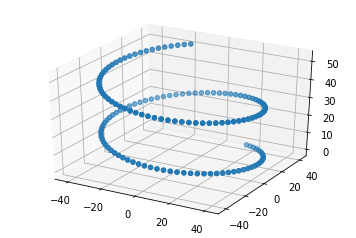

In [103]:
### Now we want to rotate the helix back so that helical axis aligns with z-axis (to test analytical formulas)

def straight_helix(i, r, psi0, T, c, b):
    phase = (2*np.pi*i*T)/b
    return np.array([r*np.cos(-phase + psi0), r*np.sin(-phase + psi0), c*phase]).T

#fix b = 146 bp (number of basepairs in 1idb nucleosome crystal structure)
straight_fit = lambda i, r, psi0, T, c: straight_helix(i, r, psi0, T, c, b=146)

#unrotated params
unrotated_params = fitted_params[[0, 4, 5, 6]] #r, psi0, T, c
bp_fullhelix = np.repeat(basepairs, 2)
rotated_fit = straight_fit(bp_fullhelix, *unrotated_params)

#Plot full helix unrotated with all 146 basepairs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rotated_fit[:,0], rotated_fit[:,1], rotated_fit[:,2])


<IPython.core.display.Javascript object>


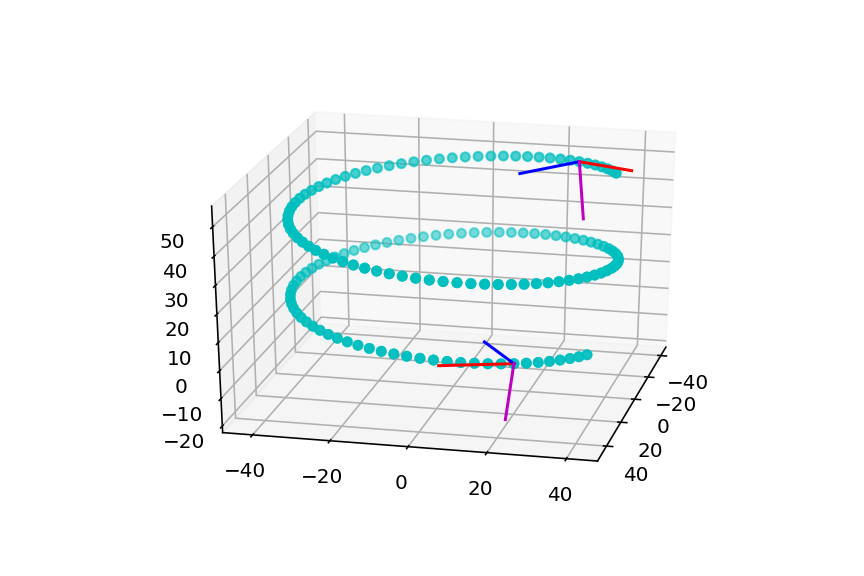

In [165]:
#Compute basis vectors of analytical helix using my formula
w_in = w_out = 7
def u(s, r, psi0, T, c, b):
    norm = 1. / np.sqrt(r**2 + c**2)
    phase = -(2*np.pi*s*T/b) + psi0
    return norm*np.array([r*np.sin(phase), -r*np.cos(phase), c])

def n(s, r, psi0, T, c, b):
    phase = -(2*np.pi*s*T/b) + psi0
    return np.array([-np.cos(phase), -np.sin(phase), 0])

def bi(s, r, psi0, T, c, b):
    return np.cross(u(s, r, psi0, T, c, b), n(s, r, psi0, T, c, b))

#returns z coordinate given x and y data of line through (x1, y1, z1) with direction vector l, m, n
#eqn of line: (x - x1)/l - (y y1)/m = (z - z1)/n
#solve for z: 
def line3d(xydata, x1, y1, z1, l, m, n):
    x = xydata[:, 0]
    y = xydata[:, 1]
    return n*(((x - x1)/l) - ((y - y1)/m)) + z1

#takes in direction vector u(s), where s = ith basepair
def draw_basis_vector(s, ux, uy, uz, col):
    #compute (x, y, z) point on helix corresponding to bp_vals
    point = straight_fit(s, *unrotated_params)
    linespan = np.linspace(0, 20, 50)
    tx = lambda s: point[0] + ux*s
    ty = lambda s: point[1] + uy*s
    tz = lambda s: point[2] + uz*s
    ax.plot(tx(linespan), ty(linespan), tz(linespan), color=col)
    
#Plot full helix unrotated with all 146 basepairs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rotated_fit[:,0], rotated_fit[:,1], rotated_fit[:,2], color="c")
#entry basis
entry = u(w_in, *unrotated_params, b=146)
entry_normal = n(w_in, *unrotated_params, b=146)
entry_binormal = bi(w_in, *unrotated_params, b=146)
B1 = np.array([entry, entry_normal, entry_binormal])
draw_basis_vector(w_in, *entry, col="r")
draw_basis_vector(w_in, *entry_normal, col="b")
draw_basis_vector(w_in, *entry_binormal, col="m")

#exit basis
exit = u(b - w_out, *unrotated_params, b=146)
exit_normal = n(b - w_out, *unrotated_params, b=146)
exit_binormal = bi(b - w_out, *unrotated_params, b=146)
B2 = np.array([exit, exit_normal, exit_binormal])
draw_basis_vector(b - w_out, *exit, col="r")
draw_basis_vector(b - w_out, *exit_normal, col="b")
draw_basis_vector(b - w_out, *exit_binormal, col="m")

#ax.view_init(1, 90)

In [ ]:
### Change of basis matrix
P = np.dot(B2, B1.T)

In [156]:
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])
project_plane([1,2,3], z)

array([ 1.,  2.,  0.])

[ 0.90754268 -0.4064857   0.10552565]


<IPython.core.display.Javascript object>


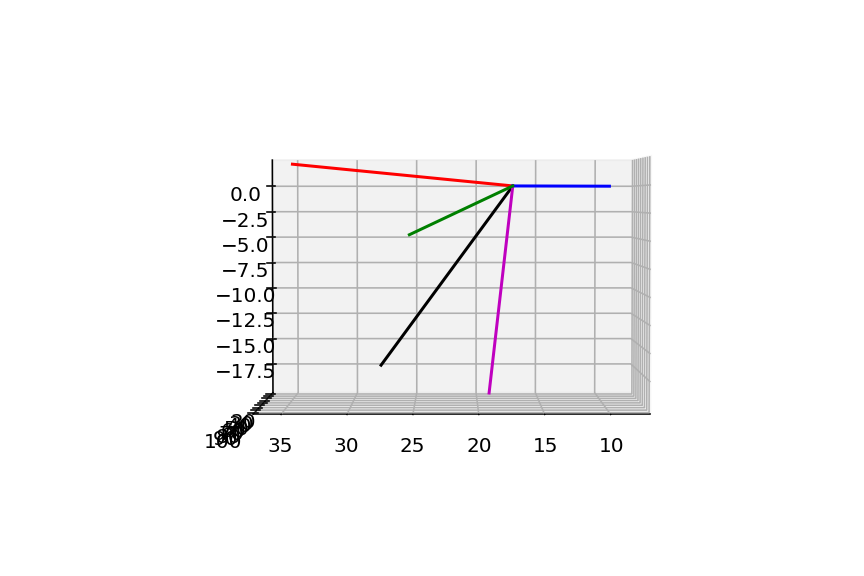

In [168]:
### Project vector onto cotangent plane

#u is tangent vector (normal vector to contangent plane)
#v is a vector defined by 2 points for each base pair
project_plane = lambda v, u: v - (np.dot(v, u)/np.linalg.norm(u)**2)*u

#extract basepairs from data (spokes_ordered)
theta = np.ones(basepairs.shape)
for i in basepairs:
    v = spokes_ordered[2*i+1, :] - spokes_ordered[2*i, :]
    p = project_plane(v, u(i, *unrotated_params, b=146))
    ct = np.dot(p, n(i, *unrotated_params, b=146))
    theta[i] = np.arccos(ct/np.linalg.norm(p))

u1 = u(0, *unrotated_params, b=146)
n1 = n(0, *unrotated_params, b=146)
b1 = bi(0, *unrotated_params, b=146)
v = spokes_ordered[1, :] - spokes_ordered[0, :]
p = project_plane(v, u1)
p = p/np.linalg.norm(p)

#check if p is indeed in the cotangent planeprint np.cross(p, n1)
cr = np.cross(n1, p)
cb =  np.cross(b1, p)

#plot the first basepair
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
draw_basis_vector(0, *v, col="k")
draw_basis_vector(0, *u1, col="r")
draw_basis_vector(0, *b1, col="m")
draw_basis_vector(0, *n1, col="b")
draw_basis_vector(0, *p, col="g")
ax.view_init(2, 90)


<IPython.core.display.Javascript object>


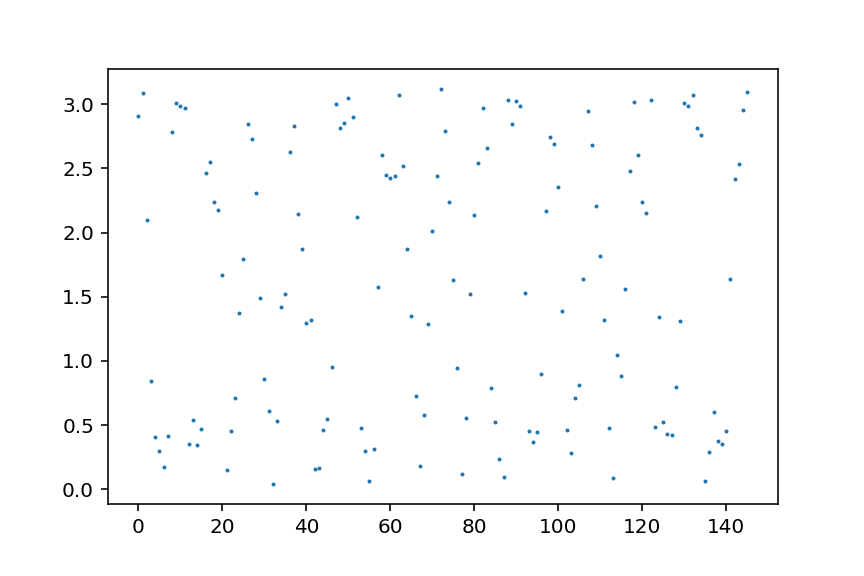

[ 2.90795178  3.08781585  2.09887859  0.84043345  0.40558649  0.29412048
  0.17430942  0.41482214  2.78422939  3.00823515  2.98719294  2.97348312
  0.35599658  0.53808453  0.34648425  0.46651739  2.46537558  2.54965882
  2.23724427  2.17605019  1.67139658  0.15065963  0.45023444  0.71175288
  1.3714119   1.79101943  2.84364525  2.72628558  2.30527532  1.4929896
  0.86076404  0.60897029  0.03856512  0.53016719  1.41875445  1.5191605
  2.63182839  2.83323699  2.14378     1.87432236  1.29736583  1.31648197
  0.15730547  0.16371673  0.46452188  0.54533503  0.95537646  2.99860495
  2.81885481  2.85346998  3.05158333  2.8991197   2.12201607  0.47464902
  0.29691312  0.06738505  0.30989819  1.57706725  2.6009535   2.4455644
  2.42208637  2.44445243  3.07599615  2.51580808  1.86993906  1.35072727
  0.72691154  0.17712457  0.58009196  1.29016477  2.0143817   2.44268068
  3.12007471  2.79397973  2.23616196  1.62857041  0.94096555  0.11475824
  0.55337411  1.52406949  2.13482308  2.54290555  2.97

In [170]:
%matplotlib notebook
plt.plot(basepairs, theta, "o", markersize = 1)
print theta

<IPython.core.display.Javascript object>


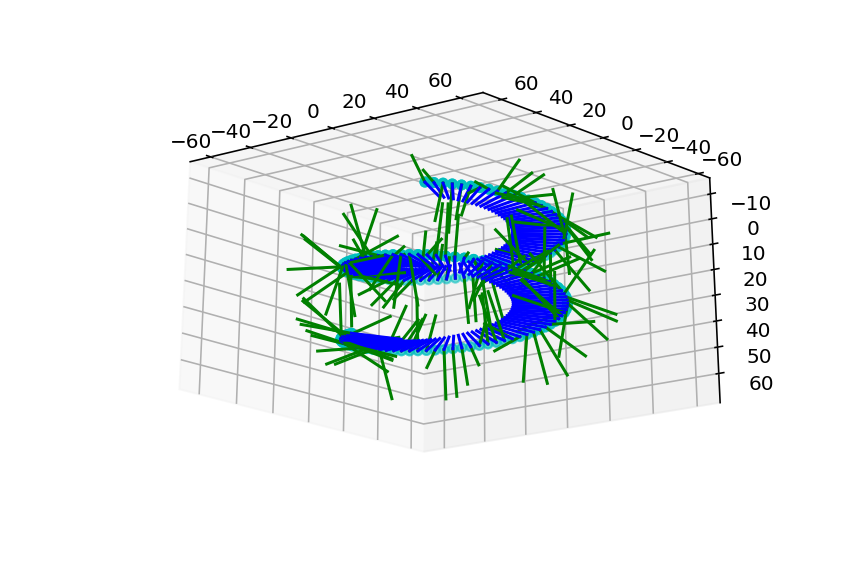

In [175]:
#Try plotting all the unprojected vectors onto analytical helix

#Plot full helix unrotated with all 146 basepairs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rotated_fit[:,0], rotated_fit[:,1], rotated_fit[:,2], color="c")

for i in basepairs:
    v = spokes_ordered[2*i+1, :] - spokes_ordered[2*i, :]
    #v = v/np.linalg.norm(v)
    p = project_plane(v, u(i, *unrotated_params, b=146))
    p = p/np.linalg.norm(p)
    ni = n(i, *unrotated_params, b=146)
    draw_basis_vector(i, *p, col = "g")
    draw_basis_vector(i, *ni, col = "b")